# Load Data

Import Libraries

In [1]:
#Code : Imports
import pandas as pd
from pandas.io.json import json_normalize
import zipfile
import json
from nltk.tokenize import TweetTokenizer
import warnings; warnings.simplefilter('ignore')
import re
import matplotlib.pyplot as plt
import seaborn as  sns

In [2]:
#Code to Load Tweet Data in a DataFrame
datafolder ='Data/'
jsonfolder='/JSON/'
zippedfilepath = 'JSON.zip'
if zippedfilepath:
    zippedFolder = zipfile.ZipFile(datafolder + zippedfilepath, 'r')
    tweetjsonfiles = zippedFolder.infolist()
else:
    tweetjsonfiles = os.listdir(datafolder + jsonfolder)

tweetsDF = pd.DataFrame()
for tweetfile in tweetjsonfiles:
    if zippedfilepath:
        currjson = json.loads(zippedFolder.open(tweetfile).read())    
    else:
        currjson = json.loads(open(datafolder + jsonfolder + tweetfile).read())    
    currtweetDF = json_normalize(currjson)
    tweetsDF = tweetsDF.append(currtweetDF)

tweetsDF.index = range(len(tweetsDF.index))


Find Sentiment of Each Tweet Based on Number of Likes

In [3]:
#Code to set Sentiment Class for each tweet
def getClass(fav):
    if fav<=4:
        return "NEG"
    elif fav>10:
        return "POS"
    else:
        return "NEU"
tweetsDF['sentiment'] = tweetsDF['favorite_count'].apply(getClass)

# Extract Features and Labels for Text Classifcation

Get Tweets in English Language

In [4]:
#Code: Filter Languages
englishfilter = tweetsDF['lang']=='en'
eng_tweets = tweetsDF[englishfilter]


### Functions for extracting features from text
-  NLTK Tweet Tokenizer user
-  User Names and URLS removed
- Punctuation removed

In [5]:
#Helper Functions for Text Feature Extraction
punct_num_rem = re.compile('[^0-9a-z #+_]')
repl_space = re.compile('[/(){}\[\]\|@,;]')

def basic_text_preprocessing(text):
    text = text.lower()
    text = re.sub(repl_space,'',text)    
    text = re.sub(punct_num_rem  ,'',text)
    return text

def ProcessTextNormal(tweet_text):
    tokens = tweet_text.replace('\n','').split()
    txt_features = []
    for t in tokens:
        tfinal = t.lower()
        
        #RemoveURLS and Username
        if tfinal[0]=='@':
            pass
        else:
            #Handle HTS
            if tfinal[0]=='#':
                tfinal = tfinal[1:]
            txt_features.append(tfinal)
    return txt_features

def tokenize_tweet(tweet_text):
    tknzr = TweetTokenizer(strip_handles=True, preserve_case= False, reduce_len=True)
    tweet_tokens = tknzr.tokenize(tweet_text)
    #print(tweet_tokens)
    temptokens= []  
    for t in tweet_tokens:
        if t[0:5]=='https':
            pass
        elif t[0]=='#':
            tf= t[1:]
            temptokens.append(tf)
        else:
            temptokens.append(t)
    finalstr =  basic_text_preprocessing(" ".join(temptokens))
    return finalstr
    
def tokenize_tweets_tweets(tweet_texts):
    
    tknzr = TweetTokenizer(strip_handles=True, preserve_case= False, reduce_len=True)
    tweet_tokens = [tknzr.tokenize(tweet_txt) for tweet_txt in tweet_texts]
    tweet_tokens_final = []
    for tokens in tweet_tokens:
        temptokens =[]
        for t in tokens:
            if len(t)==1 or t[0:5]=='https':
                pass
            elif t[0]=='#':
                tf= " "+ t[1:]
                temptokens.append(tf)
            else:
                temptokens.append(t)
        tweet_tokens_final.append(temptokens)
    return tweet_tokens_final


# TestCode
# X =candidate_data['full_text'].tolist()[0:1]
# X
# tokenize_tweets_tweets(X)

In [6]:
#Code : Extract Text Features for POS and Neg Classes
tknzr = TweetTokenizer()
normal_features = ['full_text','sentiment']
candidate_data = eng_tweets[normal_features]
classfilter = candidate_data.sentiment.isin(['POS','NEG'])
candidate_data = candidate_data[classfilter]
candidate_data.index = range(len(candidate_data.index))
candidate_data['text_features'] = candidate_data['full_text'].apply(tokenize_tweet)
candidate_data.head()

,full_text,sentiment,text_features
0,"Sharing my #Walk with #K9Jinky🐾 \nMy #Service,...",POS,sharing my walk with k9jinky my service bran...
1,With this new IoT-based crash detection #servi...,NEG,with this new iotbased crash detection service...
2,Simple Truths\nhttps://t.co/Gm4g1R2oaH\n#custo...,NEG,simple truths customers service problems truth...
3,Do you serve each other? Part of any relations...,NEG,do you serve each other part of any relations...
4,@HermanMashaba I hear you Mr mayor how Capetow...,NEG,i hear you mr mayor how capetown looks is way ...


Experimental Evaluation 

In [7]:
# Import Classifiers and Helper Librries to Evaluate
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import classification_report as ClfRep
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

classifiers = {
                'MNB' :  {'obj': MultinomialNB(), 'accuracy':0, 'prec':0, 'rec':0, 'fmeasure':0}  ,        
                'NN' :  {'obj': MLPClassifier(), 'accuracy':0, 'prec':0, 'rec':0, 'fmeasure':0} ,         
                'SGD' :  {'obj': SGDClassifier(loss='hinge', penalty='l2',\
                                 alpha=1e-3, random_state=42, max_iter=5, tol=None),\
                                'accuracy':0, 'prec':0, 'rec':0, 'fmeasure':0}   ,       
                'LogReg' :  {'obj': LogisticRegression(random_state=0), 'accuracy':0, 'prec':0, 'rec':0, 'fmeasure':0}  ,        
                'SVC' :  {'obj': LinearSVC(), 'accuracy':0, 'prec':0, 'rec':0, 'fmeasure':0}  ,        
                 'RF' :  {'obj':  RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), 'accuracy':0, 'prec':0, 'rec':0, 'fmeasure':0}      
              
              }

In [8]:
# Split Data into K FOlds and perform all experiments on this split only
def GetKFoldData(df,labelsIN, k):
    folds = {}
    labels = LabelEncoder()
    y =  labels.fit_transform(labelsIN)
    kfolds = KFold(n_splits=k, shuffle = True, random_state = 4) 
    foldidx = 0
    for train_idx, test_idx in kfolds.split(df.index):
        folds[foldidx] = {
                              'train': df.iloc[train_idx], 'test':df.iloc[test_idx], 
                              'y_train': y[train_idx], 'y_test': y[test_idx]
                         }
        foldidx+=1
    return folds


exp_data_k_folds = GetKFoldData(candidate_data, candidate_data['sentiment'] , 10)
idx_list_org = exp_data_k_folds[0]['test'].index.tolist()
exp_data_k_folds[0]['test'][0:2]

,full_text,sentiment,text_features
17,What has @JHBHope been up to? Giving #life thr...,NEG,what has been up to giving life through the g...
33,topBrass inform (https://t.co/JLFhVfUxS4) #ceo...,NEG,topbrass inform ceos cmos cios cfos look no ...


In [9]:
# Code: Helper Functions For Experiments


def GetCountVectorizerFeatures(X_tr, X_test):
    count_vectorizer = CountVectorizer()
    X_tr_vec = count_vectorizer.fit_transform(X_tr.values)
    X_test_vec = count_vectorizer.transform(X_test.values)
    return X_tr_vec,X_test_vec
    
    
def Evaluate(clfIN, X_train, X_test, y_train, y_test):
    X_tr_final = preprocessing.normalize(X_train)
    X_test_final = preprocessing.normalize(X_test)
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #X_tr_final = scaler.fit_transform(X_train)
    #X_test_final = scaler.fit_transform(X_test)
    
    trained_model =clfIN.fit(X_tr_final,y_train)
    pred = trained_model.predict(X_test_final)
    return accuracy_score(y_test,pred), precision_score(y_test,pred,average ='macro'),\
                            recall_score(y_test,pred,average ='macro'),f1_score(y_test,pred,average ='macro')
    
def RunExpCountVec(classifiers,exp_data_k_folds, featurecol):
    #print(['CLF', 'prec','rec','fmeasure','accuracy'])
    
    for clfkey,valkey in classifiers.items():
        valkey['accuracy']= 0
        valkey['prec']= 0
        valkey['rec']= 0
        valkey['fmeasure']= 0

        accuracy = 0
        precision = 0
        recall = 0 
        fmsr = 0
        for fold in exp_data_k_folds:
            train_features = exp_data_k_folds[fold]['train'][featurecol]
            test_features = exp_data_k_folds[fold]['test'][featurecol]
            X_tr_vec, X_test_vec = GetCountVectorizerFeatures(train_features, test_features)
            y_train, y_test = exp_data_k_folds[fold]['y_train'], exp_data_k_folds[fold]['y_test']
            acc, prec, rec, fmeasure = Evaluate(valkey['obj'], X_tr_vec, X_test_vec, y_train, y_test)
            accuracy += acc
            precision += prec
            recall += rec
            fmsr += fmeasure
            #folds+=1
        foldlen = len(exp_data_k_folds.items())
        valkey['accuracy']= float(accuracy/foldlen)
        valkey['prec']= float(precision/foldlen)
        valkey['rec']= float(recall/foldlen)
        valkey['fmeasure']= float(fmsr/foldlen)

        #print([clfkey, valkey['prec'],valkey['rec'],valkey['fmeasure'],valkey['accuracy']])
    return classifiers

def Dicttodataframe(dictin, idxname, columnsin = None):
    df =pd.DataFrame.from_dict(dictin, orient='index')
    if columnsin:
        df.columns = columnsin
    df.index.name = idxname
    df= df.reset_index()
    return df

def PlotRes(df, val,fontin=10,):
    g= sns.factorplot("Classifier", val, "Exp_Type" , data=df, kind="bar", size=8, aspect=2, \
                      palette="muted", legend=True)
    ax = plt.gca()
    ax.yaxis.set_tick_params(labelsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.set_xlabel("Classifier", fontsize= '16') 
    ax.set_ylabel(val, fontsize= '16') 
    #ax.set_title(title, fontsize = '16')
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/4., p.get_height(),  round(p.get_height(),3), 
                fontsize=fontin, color='red', ha='center', va='bottom')
    plt.show()

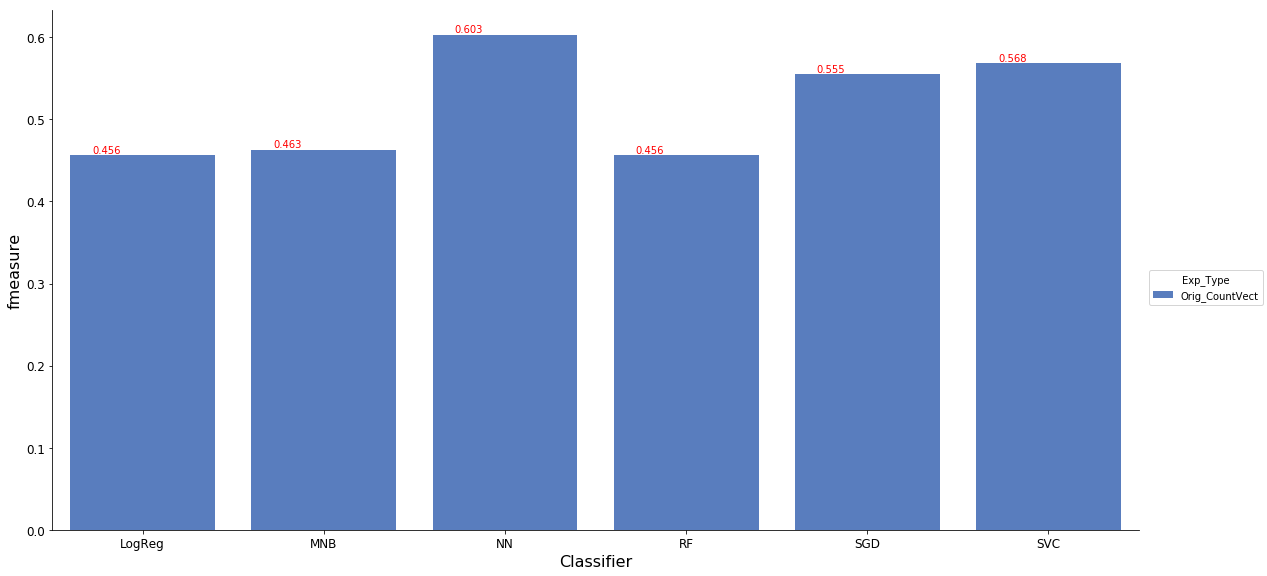

In [10]:
# Run Baseline Approach
Res1 = Dicttodataframe(RunExpCountVec(classifiers,exp_data_k_folds,'text_features'),'Classifier')
Res1['Exp_Type']  = 'Orig_CountVect'
PlotRes(Res1,'fmeasure')


In [11]:
# Old Code: Helper Functions  to Run Experiments (OLD)
# def Evaluate(clfIN, X_train, X_test, y_train, y_test,labels, vectorizer):
#     model_pipeline = Pipeline([
#                                 ('vectorizer', vectorizer),
#                                 ('clf', clfIN)
#                             ])
#     trained_model = model_pipeline.fit(X_train.values,y_train)
#     pred = trained_model.predict(X_test.values)
#     return accuracy_score(y_test,pred), precision_score(y_test,pred),\
#                             recall_score(y_test,pred),f1_score(y_test,pred)

# def RunExp(classifiers, Xcol, labelsIN, vectorizer):
#     labels = LabelEncoder()
#     X =  Xcol
#     y =  labels.fit_transform(labelsIN)
#     kfolds = KFold(n_splits=10) 
    
    
    
#     for clfkey,valkey in classifiers.items():
#         accuracy = 0
#         precision = 0
#         recall = 0 
#         fmsr = 0
#         folds = 1
#         for train_idx, test_idx in kfolds.split(X):
#             X_train, X_test = X[train_idx], X[test_idx]
#             y_train, y_test = y[train_idx], y[test_idx]
#             acc, prec, rec, fmeasure = Evaluate(valkey['obj'], X_train, X_test, y_train, y_test,labels, vectorizer)
#             accuracy += acc
#             precision += prec
#             recall += rec
#             fmsr += fmeasure
#             folds+=1

#         valkey['accuracy']= float(accuracy/folds)
#         valkey['prec']= float(precision/folds)
#         valkey['rec']= float(recall/folds)
#         valkey['fmeasure']= float(fmsr/folds)

#         print([clfkey, valkey['prec'],valkey['rec'],valkey['fmeasure'],valkey['accuracy']])



#     return folds
        


    

# Improve Perfromance

Some of the ways accuracy can be improved are (I have focused on F-Measure metric but results can be easily plotted for other  )
- Adding New Classifiers ( Have tested 5 classifiers already so ignoring it in further experiments)
- More/Different Preprocessing of Text such as  
    - ignoring 1 character features
    - lematization 
 
- Using a Different Representation
    - Using Representatin such as TFIDF
    - Using Representatin such as Word2vec (Not implemented )
    
-  Adding Features Other Than Text 
    - Popularity features : How many times the tweet was retweeted
    - User importance features : How popular are they

### Text Features Modified (More preprocessing added)
- Stemming Added
- Remove Length 1 tokens

#### (Very Minor Improvement Achieved)

In [12]:
# Do More Text Processing
import nltk
def MoreTextProcessing(sentence):
    stemmer = nltk.stem.WordNetLemmatizer()
    tokens = sentence.split()
    tokens = [t for t in tokens if len(t)>1]
    tokens= " ".join(stemmer.lemmatize(t) for t in tokens)
    return tokens
 
candidate_data['text_features_new'] = candidate_data['text_features'].apply(MoreTextProcessing)
candidate_data.head()                                                                           
# X= candidate_data['text_features'].tolist()[0]
# print(X)
# print(MoreTextProcessing(X))

,full_text,sentiment,text_features,text_features_new
0,"Sharing my #Walk with #K9Jinky🐾 \nMy #Service,...",POS,sharing my walk with k9jinky my service bran...,sharing my walk with k9jinky my service branch...
1,With this new IoT-based crash detection #servi...,NEG,with this new iotbased crash detection service...,with this new iotbased crash detection service...
2,Simple Truths\nhttps://t.co/Gm4g1R2oaH\n#custo...,NEG,simple truths customers service problems truth...,simple truth customer service problem truth ho...
3,Do you serve each other? Part of any relations...,NEG,do you serve each other part of any relations...,do you serve each other part of any relationsh...
4,@HermanMashaba I hear you Mr mayor how Capetow...,NEG,i hear you mr mayor how capetown looks is way ...,hear you mr mayor how capetown look is way bet...


In [13]:
# Split Data Also Smalll Check to See if it is same as original experiment
exp_data_k_folds = GetKFoldData(candidate_data, candidate_data['sentiment'] , 10)
idx_list_new = exp_data_k_folds[0]['test'].index.tolist()
assert(sum([i-j for i,j in zip(idx_list_new,idx_list_org)])==0)

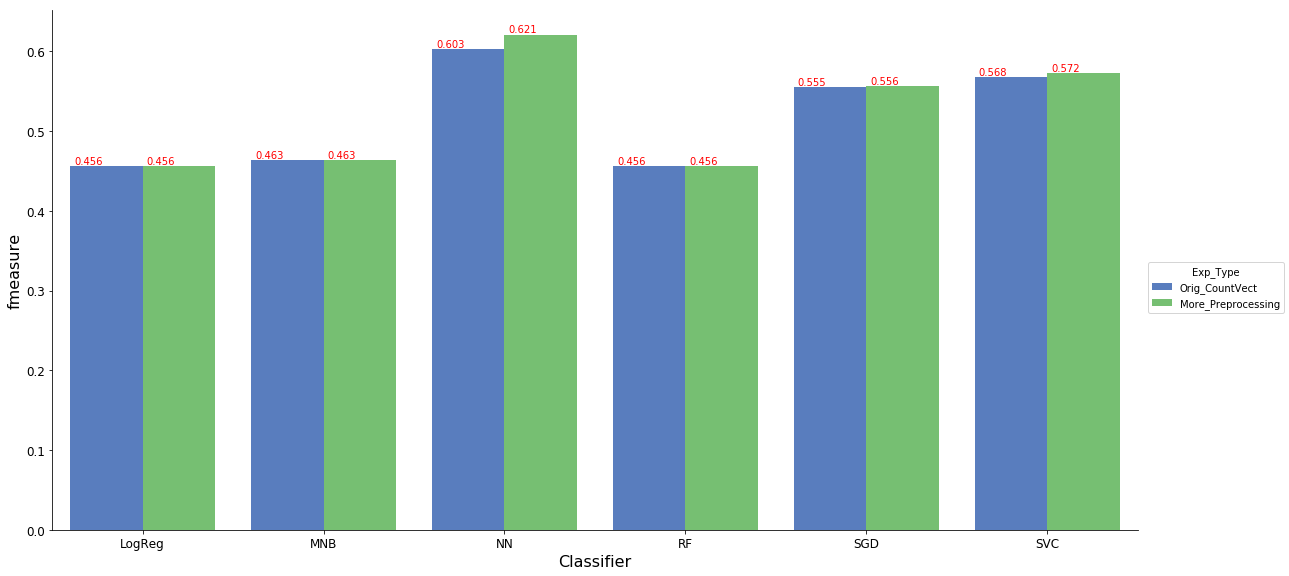

In [14]:
# Run after more preprocessing and Compare Against Previous
Res2 = Dicttodataframe(RunExpCountVec(classifiers,exp_data_k_folds,'text_features_new'),'Classifier')
Res2['Exp_Type'] = 'More_Preprocessing'
DF = pd.concat([Res1,Res2])
DF.index = range(len(DF.index))
PlotRes(DF,'fmeasure')


## Checking If TFIDF Represenation Improves Performance

### Does not help much

In [15]:
# Edited Helper Code 
def GetTFIDFFeatures(X_tr, X_test, vectorizer =TfidfVectorizer()):
    tfidf = vectorizer
    X_tr_vec = count_vectorizer.fit_transform(X_tr.values)
    X_test_vec = count_vectorizer.transform(X_test.values)
    return X_tr_vec,X_test_vec
    

    
def RunAnyVec(classifiers,exp_data_k_folds, featurecol,vectorizer):
    vectype = str(type(vectorizer))
    for clfkey,valkey in classifiers.items():
        valkey['accuracy']= 0
        valkey['prec']= 0
        valkey['rec']= 0
        valkey['fmeasure']= 0

        accuracy = 0
        precision = 0
        recall = 0 
        fmsr = 0
        for fold in exp_data_k_folds:
            train_features = exp_data_k_folds[fold]['train'][featurecol]
            test_features = exp_data_k_folds[fold]['test'][featurecol]
            if vectype =='sklearn.feature_extraction.text.TfidfVectorizer':
                X_tr_vec, X_test_vec = GetTFIDFFeatures(train_features, test_features, vectorizer)
            else:
                X_tr_vec, X_test_vec = GetCountVectorizerFeatures(train_features, test_features)
            y_train, y_test = exp_data_k_folds[fold]['y_train'], exp_data_k_folds[fold]['y_test']
            acc, prec, rec, fmeasure = Evaluate(valkey['obj'], X_tr_vec, X_test_vec, y_train, y_test)
            accuracy += acc
            precision += prec
            recall += rec
            fmsr += fmeasure
            #folds+=1
        foldlen = len(exp_data_k_folds.items())
        valkey['accuracy']= float(accuracy/foldlen)
        valkey['prec']= float(precision/foldlen)
        valkey['rec']= float(recall/foldlen)
        valkey['fmeasure']= float(fmsr/foldlen)

        #print([clfkey, valkey['prec'],valkey['rec'],valkey['fmeasure'],valkey['accuracy']])
    return classifiers

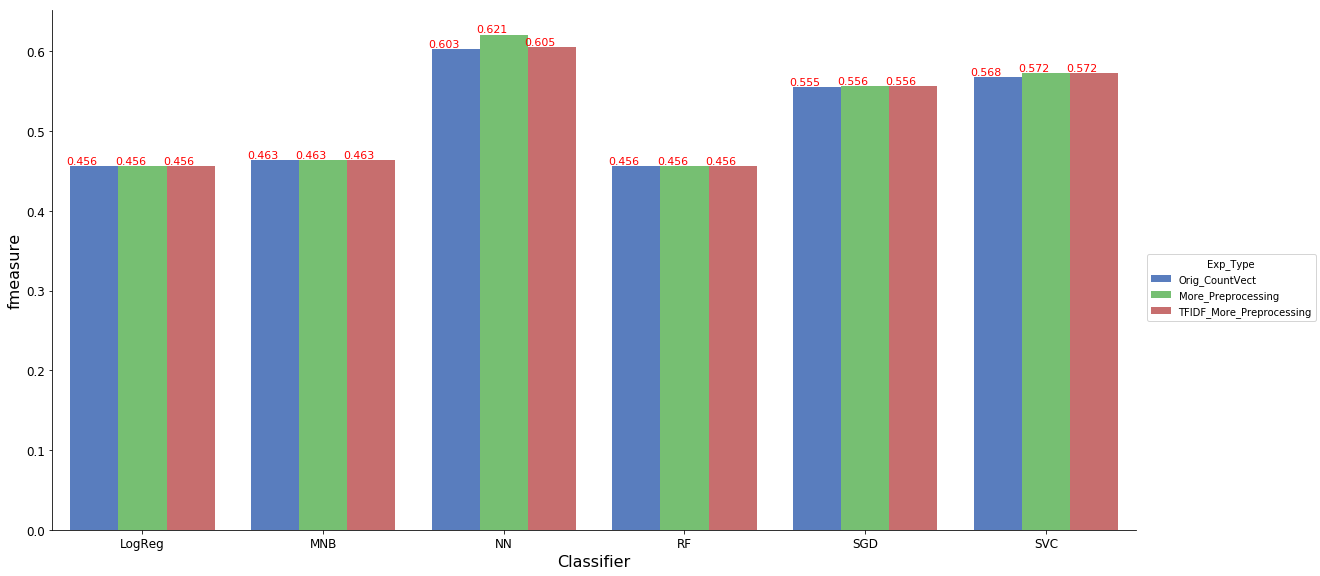

In [16]:
# Code: TFIDF WITH NeW FEATURES
vectype = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
Res3 = Dicttodataframe(RunAnyVec(classifiers,exp_data_k_folds,'text_features_new', vectype),'Classifier')
Res3['Exp_Type'] = 'TFIDF_More_Preprocessing'
DF = pd.concat([DF,Res3])
DF.index = range(len(DF.index))
PlotRes(DF,'fmeasure', fontin = 11)


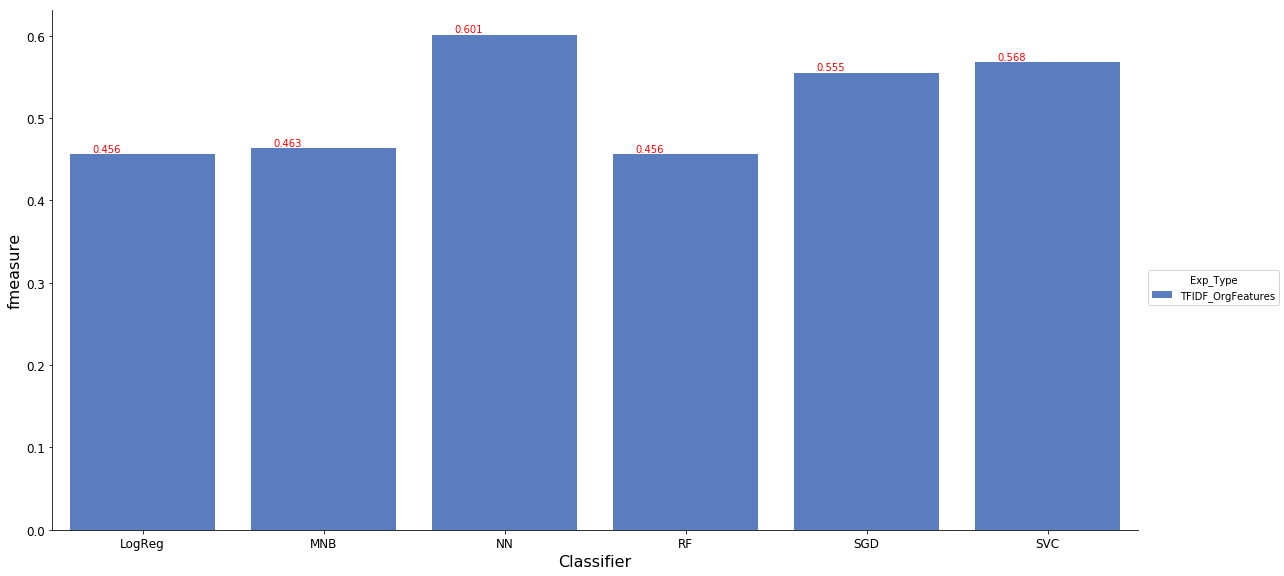

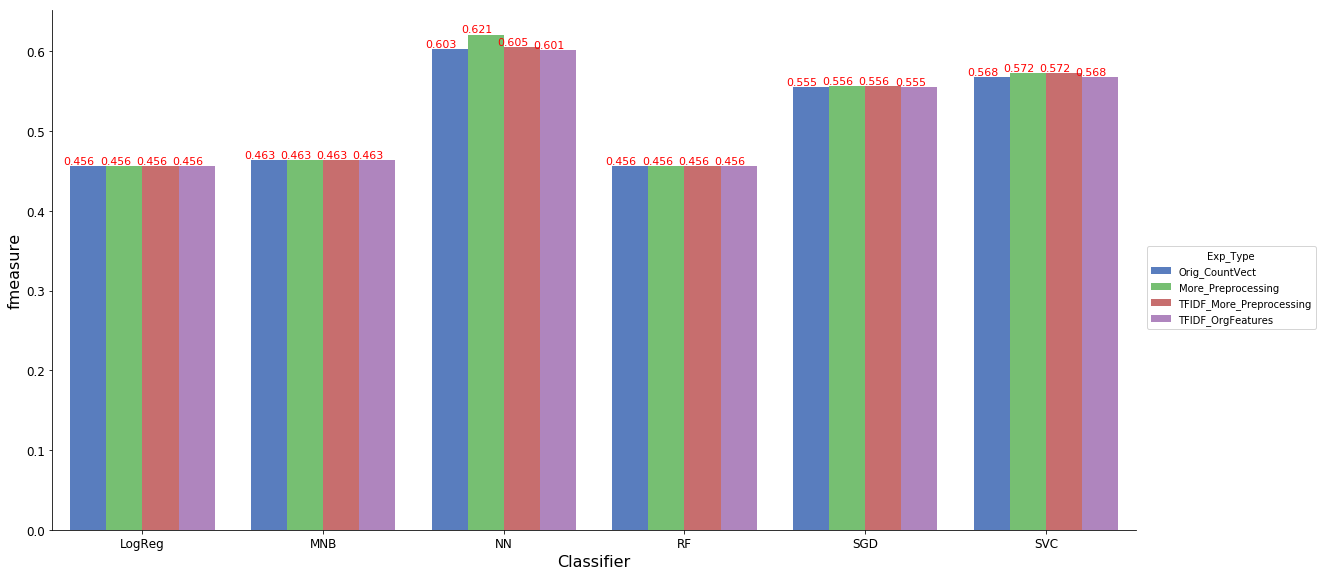

In [17]:
# Code: TFIDF WITH OLD FEATURES
Res4 = Dicttodataframe(RunAnyVec(classifiers,exp_data_k_folds,'text_features', vectype),'Classifier')
Res4['Exp_Type'] = 'TFIDF_OrgFeatures'
PlotRes(Res4,'fmeasure')
DF = pd.concat([DF,Res4])
DF.index = range(len(DF.index))
PlotRes(DF,'fmeasure', fontin = 11)

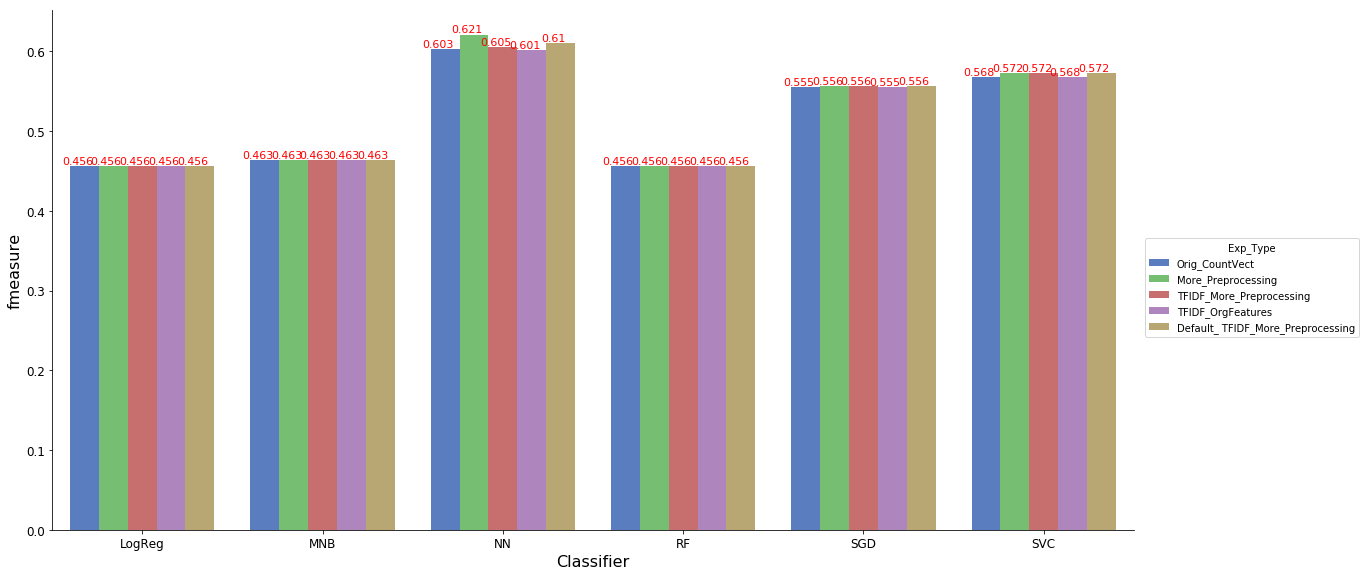

In [18]:
# Code: TFIDF WITH NeW FEATURES
vectype = TfidfVectorizer()
Res5 = Dicttodataframe(RunAnyVec(classifiers,exp_data_k_folds,'text_features_new', vectype),'Classifier')
Res5['Exp_Type'] = 'Default_ TFIDF_More_Preprocessing'
DF = pd.concat([DF,Res5])
DF.index = range(len(DF.index))
PlotRes(DF,'fmeasure', fontin = 11)


## Check if adding  more Features helps improve performance

Features Considered
-  Popularity Features such as retweet count
- User Features such as Number of Friends and Followers of the Person who tweeted

In [19]:
# Load Data with New Features
normal_features = ['full_text','sentiment']
pop_features = ['retweet_count']
user_features = ['user.friends_count','user.followers_count','user.listed_count']
candidate_data_new = eng_tweets[normal_features + pop_features + user_features]
classfilter = candidate_data_new.sentiment.isin(['POS','NEG'])
candidate_data_new = candidate_data_new[classfilter]
candidate_data_new.index = range(len(candidate_data_new.index))
candidate_data_new['text_features'] = candidate_data['full_text'].apply(tokenize_tweet)
candidate_data_new['text_features_new'] = candidate_data['text_features'].apply(MoreTextProcessing)
candidate_data_new.head(2)

,full_text,sentiment,retweet_count,user.friends_count,user.followers_count,user.listed_count,text_features,text_features_new
0,"Sharing my #Walk with #K9Jinky🐾 \nMy #Service,...",POS,23,9930,9925,28,sharing my walk with k9jinky my service bran...,sharing my walk with k9jinky my service branch...
1,With this new IoT-based crash detection #servi...,NEG,1,10,6465,96,with this new iotbased crash detection service...,with this new iotbased crash detection service...


In [20]:
# Split Data Also Smalll Check to See if it is same as original experiment
exp_data_k_folds = GetKFoldData(candidate_data_new, candidate_data['sentiment'] , 10)
idx_list_new = exp_data_k_folds[0]['test'].index.tolist()
assert(sum([i-j for i,j in zip(idx_list_new,idx_list_org)])==0)
exp_data_k_folds[0]['test'][0:2]

,full_text,sentiment,retweet_count,user.friends_count,user.followers_count,user.listed_count,text_features,text_features_new
17,What has @JHBHope been up to? Giving #life thr...,NEG,2,58,841,58,what has been up to giving life through the g...,what ha been up to giving life through the gif...
33,topBrass inform (https://t.co/JLFhVfUxS4) #ceo...,NEG,2,5015,2743,10,topbrass inform ceos cmos cios cfos look no ...,topbrass inform ceo cmos cio cfo look no furth...


In [21]:
#Edited Helper Code For Handling Extra Features 
#from sklearn_pandas import DataFrameMapper
import scipy as sp

def RunAnyVecNew(classifiers, exp_data_k_folds, featurecol,vectorizer, added_features = None):
    vectype = str(type(vectorizer))
    for clfkey,valkey in classifiers.items():
        valkey['accuracy']= 0
        valkey['prec']= 0
        valkey['rec']= 0
        valkey['fmeasure']= 0

        accuracy = 0
        precision = 0
        recall = 0 
        fmsr = 0
        for fold in exp_data_k_folds:
            train_features = exp_data_k_folds[fold]['train'][featurecol]
            test_features = exp_data_k_folds[fold]['test'][featurecol]
            
            if vectype =='sklearn.feature_extraction.text.TfidfVectorizer':
                X_tr_vec, X_test_vec = GetTFIDFFeatures(train_features, test_features, vectorizer)
            else:
                X_tr_vec, X_test_vec = GetCountVectorizerFeatures(train_features, test_features)
            
            
            y_train, y_test = exp_data_k_folds[fold]['y_train'], exp_data_k_folds[fold]['y_test']
            if added_features:
                other_features_train = exp_data_k_folds[fold]['train'][added_features]
                other_features_test = exp_data_k_folds[fold]['test'][added_features]                
                X_tr_vec = sp.sparse.hstack((X_tr_vec,other_features_train.values),format='csr')
                X_test_vec = sp.sparse.hstack((X_test_vec,other_features_test.values),format='csr')

            
            acc, prec, rec, fmeasure = Evaluate(valkey['obj'], X_tr_vec, X_test_vec, y_train, y_test)
            accuracy += acc
            precision += prec
            recall += rec
            fmsr += fmeasure
            #folds+=1
        foldlen = len(exp_data_k_folds.items())
        valkey['accuracy']= float(accuracy/foldlen)
        valkey['prec']= float(precision/foldlen)
        valkey['rec']= float(recall/foldlen)
        valkey['fmeasure']= float(fmsr/foldlen)

        #print([clfkey, valkey['prec'],valkey['rec'],valkey['fmeasure'],valkey['accuracy']])
    return classifiers

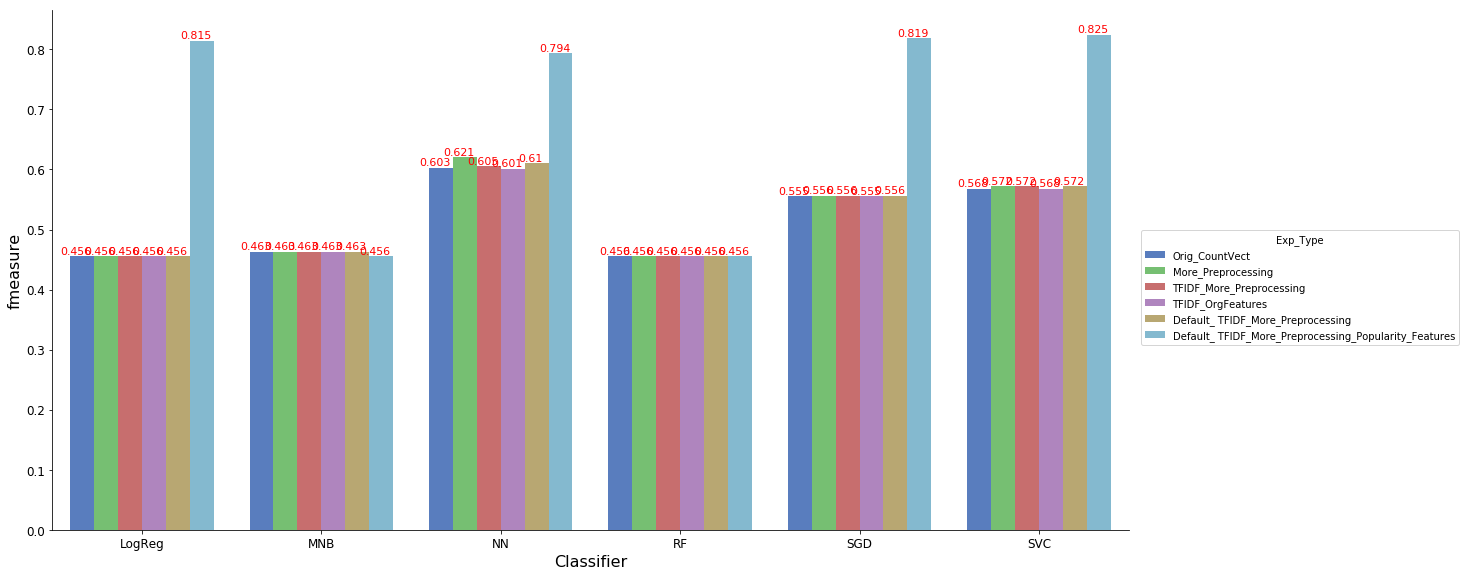

In [22]:
# Code: TFIDF WITH POPULATION FEATURES ADDED
vectype = TfidfVectorizer()
Res6 = Dicttodataframe(RunAnyVecNew(classifiers,exp_data_k_folds,'text_features_new', vectype, pop_features),'Classifier')
Res6['Exp_Type'] = 'Default_ TFIDF_More_Preprocessing_Popularity_Features'
DF = pd.concat([DF,Res6])
DF.index = range(len(DF.index))
PlotRes(DF,'fmeasure', fontin = 11)


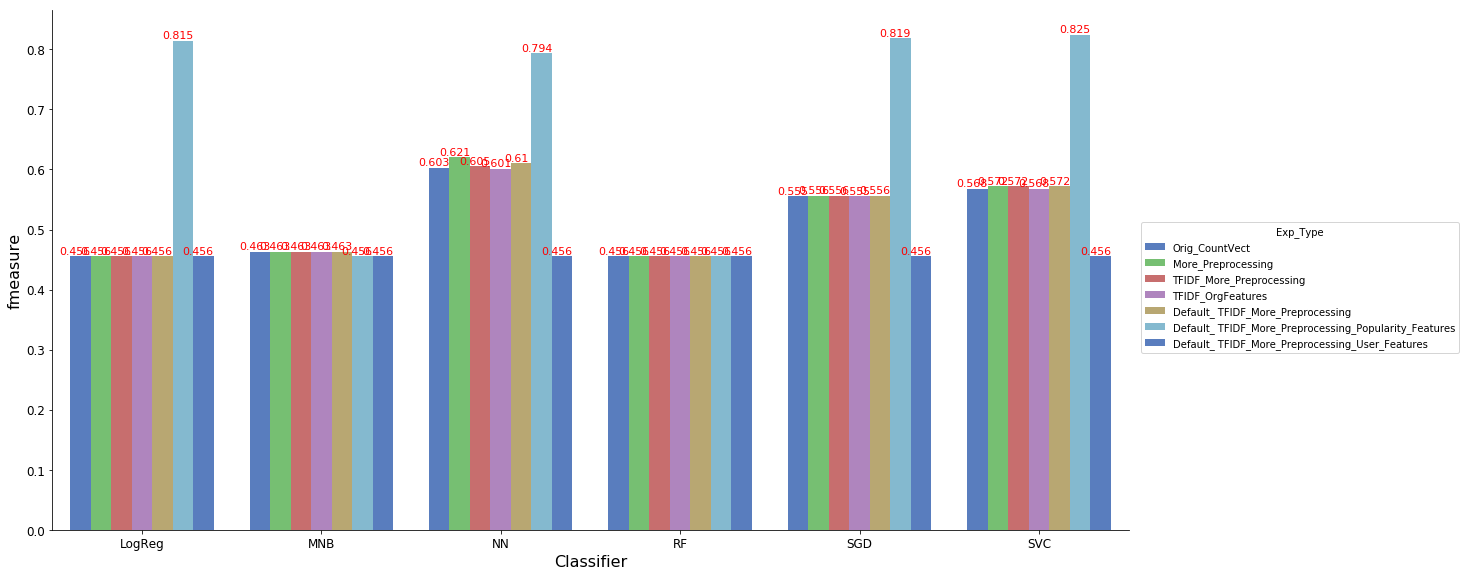

In [23]:
# Code: TFIDF WITH USER FEATURES ADDED
vectype = TfidfVectorizer()
Res7 = Dicttodataframe(RunAnyVecNew(classifiers,exp_data_k_folds,'text_features_new', vectype, user_features),'Classifier')
Res7['Exp_Type'] = 'Default_ TFIDF_More_Preprocessing_User_Features'
DF = pd.concat([DF,Res7])
DF.index = range(len(DF.index))
PlotRes(DF,'fmeasure', fontin = 11)


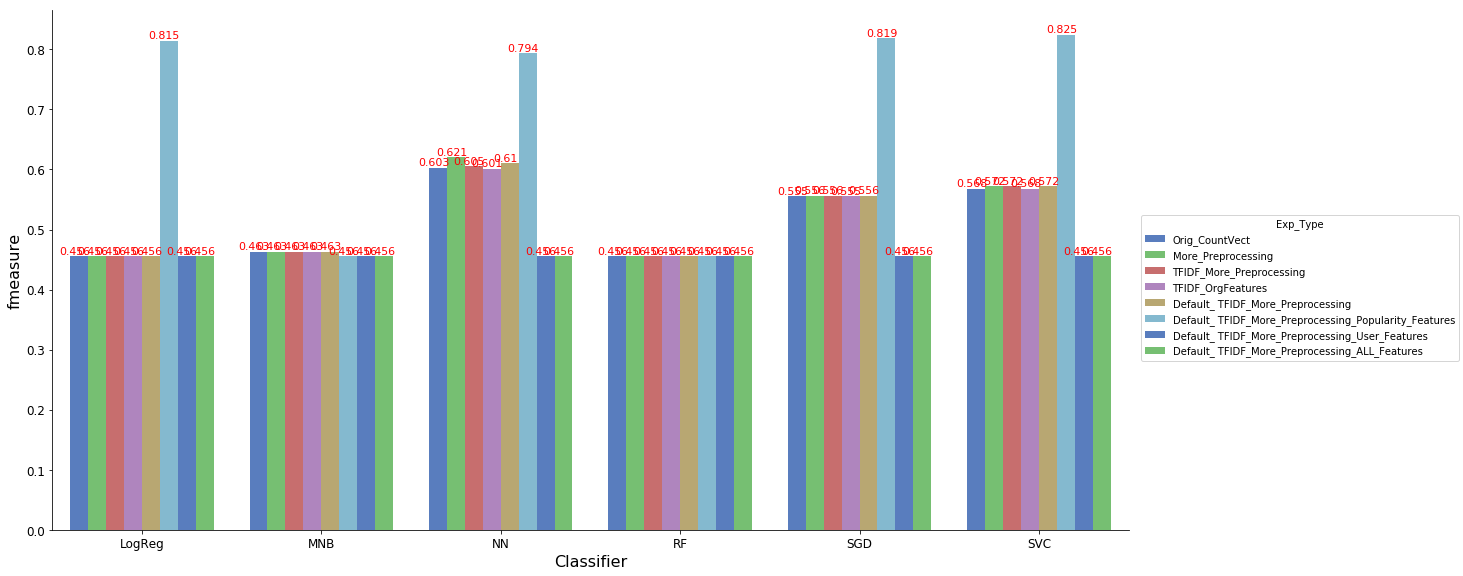

In [26]:
# Code: TFIDF WITH ALL FEATURES ADDED
vectype = TfidfVectorizer()
Res8 = Dicttodataframe(RunAnyVecNew(classifiers,exp_data_k_folds,'text_features_new', vectype, pop_features + user_features),'Classifier')
Res8['Exp_Type'] = 'Default_ TFIDF_More_Preprocessing_ALL_Features'
DF = pd.concat([DF,Res8])
DF.index = range(len(DF.index))
PlotRes(DF,'fmeasure', fontin = 11)


In [ ]:
# # W2V (Late if time permits)

# import gensim
# model = gensim.models.Word2Vec(candidate_data['text_features'].values, size=100)
# w2v = dict(zip(model.wv.index2word, model.wv.syn0))

# # Code taken from http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
# class MeanEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         # if a text is empty we should return a vector of zeros
#         # with the same dimensionality as all the other vectors
#         self.dim = len(word2vec.itervalues().next())

#     def fit(self, X, y):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])


    
# RunExp(classifiers, candidate_data['text_features'], candidate_data['sentiment'], MeanEmbeddingVectorizer(w2v))